# Prompt tune a Granite model using watsonx

**Author**: Anna Gutowska 

In this tutorial, we will prompt tune an [IBM® Granite™ Model](https://www.ibm.com/granite) using a synthetic dataset containing customer reviews of a dog grooming business. 

Prompt tuning is an efficient, low-cost way of adapting an [artificial intelligence (AI)](https://www.ibm.com/topics/artificial-intelligence) foundation model to new downstream tasks without retraining the entire model and updating its weights.

# Overview of LLM optimization 
[Foundation models](https://research.ibm.com/blog/what-are-foundation-models) are built on [large language models (LLMs)](https://www.ibm.com/topics/large-language-models) and receive large amounts of training data. Common use cases of foundation models are [chatbots](https://www.ibm.com/topics/chatbots) and virtual assistants. 

There are several ways of improving a foundation model's interpretation of input and its quality of responses. To better understand these nuances, let's compare some of the methods.

* [**Prompt engineering**](https://www.ibm.com/topics/prompt-engineering) is the optimization of a pretrained model's responses by providing a well-designed prompt. No new data is introduced using this technique and the model remains as-is. Using this method, the model receives an input prompt and an engineered prompt in front of it. For instance, you can use the prompt: "Translate English to Spanish," with the input: "good morning." This method requires more work from the user. However, this manual human effort to formulate effective prompts helps generative AI models produce task-specific responses without retraining the entire foundation model. 

* [**Fine-tuning**](https://www.ibm.com/topics/fine-tuning) large language models involves tuning the same model by providing large numbers of labeled datasets. Fine-tuning alters the model weights and becomes difficult to manage as tasks become diversified. This requires a significant amount of computational resources. In turn, this method tends to have the best accuracy since the model can be trained for very specific use cases. 

* Unlike fine-tuning, [**prompt tuning**](https://research.ibm.com/blog/what-is-ai-prompt-tuning) does not alter the pre-trained model weights. Instead, this technique is parameter-efficient by adjusting prompt parameters to guide the model’s responses in the preferred direction. The model is provided with an input and tunable soft prompts generated by the AI itself. This task-specific context guides the massive model to tailor its responses to a narrow task even with limited data.

* Similarly to prompt tuning, [**prefix-tuning**](https://arxiv.org/pdf/2101.00190) (link resides outside [ibm.com](ibm.com)) involves the model receiving several examples of preferred output. The difference here is that a prefix, a series of task-specific vectors, is also included. Prefix-tuning involves both soft prompts and prompts injected into layers of the deep learning model. These so-called "virtual tokens" allow the tuned model the flexibility to support a variety of new tasks at once. This method achieves similar performance to fine-tuning all layers and only trains about 0.1% of the parameters. Prefix-tuning even outperforms fine-tuning in low data settings. 

# Soft prompts versus hard prompts 

Hard prompts are user-facing and require user action. A hard prompt can be thought of as a template or instructions for the LLM to generate responses. An example of a hard prompt is introduced next. We encourage you to check out the [IBM documentation page](https://ibm.github.io/watson-machine-learning-sdk/tune_experiment.html) for more information on this prompt type and several others. 

In [ ]:
###For demonstration purposes only. It is not necessary to run this code block.
hard_prompt_template = """Generate a summary of the context that answers the question. Explain the answer in multiple steps if possible. 
Answer style should match the context. Ideal Answer length is 2-3 sentences.\n\n{context}\nQuestion: {question}\nAnswer:
"""

Using this hard prompt template, an LLM can be provided with specific instructions on the preferred output structure and style. Through this explicit prompt, the LLM would be more likely to produce desirable responses of higher quality. 

Soft prompts, unlike hard prompts, are not written in natural language. Instead, prompts are initialized as AI-generated, numerical vectors appended to the start of each input [embedding](https://www.ibm.com/topics/embedding) that distill knowledge from the larger model. This lack of interpretability extends to the AI that chooses prompts optimized for a given task. Often, the AI is unable to explain why it chose those embeddings. In comparison to other prompting methods, these virtual tokens are less computationally expensive than fine-tuning since the model itself remains frozen with fixed weights. Soft prompts also tend to outperform human-engineered hard prompts. 

We will be working with soft prompts for prompt tuning in this tutorial.


# Prerequisites

You need an [IBM Cloud® account](https://cloud.ibm.com/registration?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-create-langchain-rag-system-python-watsonx&cm_sp=ibmdev-_-developer-_-trial) to create a [watsonx.ai™](https://www.ibm.com/products/watsonx-ai?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-create-langchain-rag-system-python-watsonx&cm_sp=ibmdev-_-developer-_-product) project.

# Steps

## Step 1. Set up your environment

While you can choose from several tools, this tutorial walks you through how to set up an IBM account to use a Jupyter Notebook. 

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-create-langchain-rag-system-python-watsonx&cm_sp=ibmdev-_-developer-_-trial) using your IBM Cloud account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-create-langchain-rag-system-python-watsonx&topic=projects-creating-project&cm_sp=ibmdev-_-developer-tutorials-_-ibmcom).

	You can get your project ID from within your project. Click the **Manage** tab. Then, copy the project ID from the **Details** section of the **General** page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-create-langchain-rag-system-python-watsonx&topic=editor-creating-managing-notebooks&cm_sp=ibmdev-_-developer-tutorials-_-ibmcom).

This step will open a Notebook environment where you can copy the code from this tutorial to implement prompt tuning on your own.  Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. To view more Granite tutorials, check out the [IBM Granite Community](https://github.com/ibm-granite-community). This tutorial is also available on [Github](https://github.com/IBM/ibmdotcom-tutorials/tree/main/generative-ai/prompt-tuning.ipynb).

## Step 2. Set up a watsonx.ai Runtime instance and API key.

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (select your appropriate region and choose the Lite plan, which is a free instance).

2. Generate an [API Key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html). 

3. Associate the watsonx.ai Runtime service instance to the project that you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html). 


## Step 3. Install and import relevant libraries and set up your credentials

We'll need a few libraries and modules for this tutorial. Make sure to import the following ones; if they're not installed, you can resolve this with a quick pip install.

In [ ]:
#installations 
%pip install ibm-watsonx-ai | tail -n 1
%pip install pandas | tail -n 1
%pip install wget | tail -n 1
%pip install scikit-learn | tail -n 1
%pip install matplotlib | tail -n 1

In [ ]:
#imports
import wget
import pandas as pd
import getpass

from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes
from ibm_watsonx_ai.experiment import TuneExperiment
from ibm_watsonx_ai.helpers import DataConnection
from ibm_watsonx_ai.foundation_models import ModelInference
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

Set up your credentials.

In [ ]:
credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": getpass.getpass("Please enter your watsonx.ai Runtime API key (hit enter): ")
}

project_id = getpass.getpass("Please enter your project ID (hit enter): ")

## Step 4. Establish environment and import dataset

As the first step in establishing the environment, create an instance of APIClient with your authentication details and set your `project_id`. 

In [ ]:
client = APIClient(credentials)
client.set.default_project(project_id)

For this tutorial, we will be using a synthetic dataset consisting of dog grooming business reviews. Using the appropriate URL, we can connect the dataset to the API client. 

You are free to use any dataset of your choice. Several [open-source](https://www.ibm.com/topics/open-source) datasets are available on platforms such as HuggingFace.

In [ ]:
train_filename = 'dog_grooming_reviews_train_data.json'

url = "https://raw.githubusercontent.com/AnnaGutowska/think/main/tutorials/prompt-tuning-tutorial/" + train_filename
wget.download(url)

asset_details = client.data_assets.create(name=train_filename, file_path=train_filename)
asset_id = client.data_assets.get_id(asset_details)

Creating data asset...
SUCCESS


In [ ]:
print(asset_id)

3b1db894-8d9e-428d-8fee-d96f328c7726


To gain some insight into the formatting of these customer reviews, let's load the data into a Pandas dataframe and print a few rows that show both positive and negative reviews. An output of "1" denotes positive reviews and "0" is used for negative reviews. 

In [ ]:
pd.set_option('display.max_colwidth', None)
df = pd.read_json(train_filename)
df[5:10]

,input,output
5,"Comment: I have been taking my dog to this groomer for a while now and I have always been impressed with the service. The groomers are skilled and patient, especially with my dog who can be quite nervous around new people. They take their time to make sure my dog looks great and never rush through the process. The prices are also very reasonable. I would definitely recommend this groomer to others!\nSatisfaction:\n",1
6,Comment: I had a very poor experience at this grooming salon. The groomer was not very experienced and made several mistakes while grooming my dog. The fur was left all over my house and furniture. I called to express my concerns and was met with dismissiveness and arrogance. I will not be returning to this groomer.\nSatisfaction:\n,0
7,Comment: I took my dog to this groomer for the first time and was very disappointed. The groomer was rushing through the process and did not seem to pay attention to detail. My dog came out with matted fur and dirty paws. I will not be returning to this groomer.\nSatisfaction:\n,0
8,"Comment: I have been taking my dog to this groomer for years, but I have recently started having issues with the service. The groomers seem to be in a hurry and do not seem to care about the quality of their work. My dog has come out with cuts and bruises on multiple occasions. I am considering finding a new groomer.\nSatisfaction:\n",0
9,Comment: My dog is always super excited to visit this groomer. I always have a positive experience here!\nSatisfaction:\n,1


## Step 5. Tune the model.

The [`TuneExperiment`](https://ibm.github.io/watson-machine-learning-sdk/tune_experiment.html) class is used to create experiments and schedule tunings. Let's use it to initialize our experiment and set our base foundation model, training data and parameters. The goal of this prompt tuning exercise is for the LLM to tailor its responses in accordance with the extracted customer satisfaction ratings from our dataset. This is a classification task since the reviews can be classified as either positive ("1") or negative ("0"). 

For this tutorial, we suggest using an [IBM Granite Model](https://www.ibm.com/granite) as the large language model to achieve similar results. 

In [ ]:
experiment = TuneExperiment(credentials,
    project_id=project_id
)

prompt_tuner = experiment.prompt_tuner(name="prompt tuning tutorial",
    task_id=experiment.Tasks.CLASSIFICATION,
    base_model=ModelTypes.GRANITE_13B_INSTRUCT_V2,
    accumulate_steps=16,
    batch_size=8,
    learning_rate=0.001,
    max_input_tokens=128,
    max_output_tokens=2,
    num_epochs=12,
    tuning_type=experiment.PromptTuningTypes.PT,
    init_text="Extract the satisfaction from the comment. Return simple '1' for satisfied customer or '0' for unsatisfied. Comment:",
    init_method="text",
    verbalizer="classify {0, 1} {{input}}",
    auto_update_model=True
)

Now that we have our tuning experiment set up, we need to connect it to our dataset. For this, let's use the [`DataConnection`](https://ibm.github.io/watsonx-ai-python-sdk/dataconnection_modules.html) class. This requires  the `asset_id` we produced earlier upon initiating the data asset with our API client.

In [ ]:
data_conn = DataConnection(data_asset_id=asset_id)

You are free to use an AI model of your choice. The foundation models available to tune through watsonx can be found [here](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-model-choose.html?context=wx&audience=wdp) or by running the following command.

In [ ]:
client.foundation_models.PromptTunableModels.show()

We are now ready to begin the prompt tuning process. The progress will be shown once you run the following cell. This should take approximately 10 to 15 minutes.

In [ ]:
tuning_details = prompt_tuner.run(
    training_data_references=[data_conn],
    background_mode=False)



##############################################

Running '20671f17-ff53-470b-9bfe-04318ecb91d9'

##############################################


pending......
running....................................................................................................................................
completed
Training of '20671f17-ff53-470b-9bfe-04318ecb91d9' finished successfully.


## Step 6. Evaluate tuning results.

To ensure our prompt tuning has concluded, we can check the status. If the status that prints is anything other than "completed," please wait for the tuning to finish before continuing.  

In [ ]:
status = prompt_tuner.get_run_status()
print(status)

completed


We can now retrieve the prompt tuning summary. In this summary, you will see a loss value. For each training run, the loss function measures the difference between the predicted and actual results. Hence, a lower loss value is preferred. 

In [ ]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_20671f17-ff53-470b-9bfe-04318ecb91d9,[prompt_tuning],ibm/granite-13b-instruct-v2,True,12,0.010478


We can also plot the learning curve of our model tuning using the `plot_learning_curve()` function. A downward-sloping curve that levels off close to zero indicates that the model is improving its expected output generation. To learn more about interpreting loss function graphs, see the relevant [IBM watsonx documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-methodology.html?context=wx&audience=wdp).

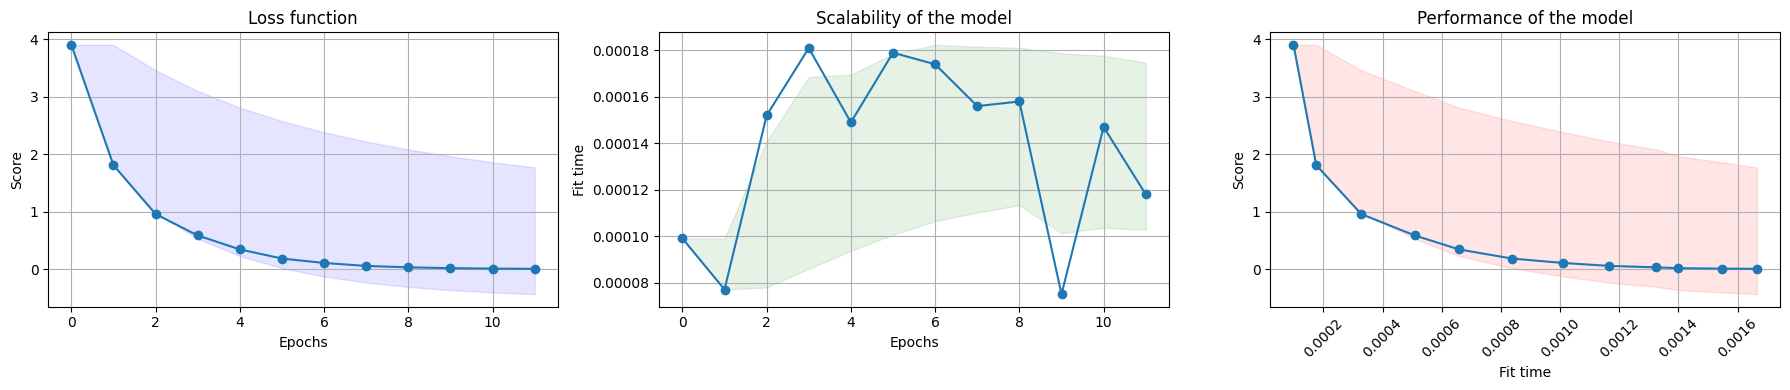

In [ ]:
prompt_tuner.plot_learning_curve()

## Step 7. Deploy the tuned model.

This step of deploying the tuned model is critical for completing the next step of comparing the performance of the tuned model to the pretuned model. 

Note: The `SERVING_NAME` is set to the current date and time since it must be a unique value.

In [ ]:
model_id = prompt_tuner.get_model_id()

meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PROMP TUNE DEPLOYMENT",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : datetime.now().strftime('%Y_%m_%d_%H%M%S')
}

deployment_details = client.deployments.create(model_id, meta_props)



######################################################################################

Synchronous deployment creation for id: '6aa5dd5c-0cc4-44e0-9730-18303e88e14a' started

######################################################################################


initializing.......................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='24a97b84-47d0-4490-9f5f-21ed2376fdd6'
-----------------------------------------------------------------------------------------------




## Step 8. Test the tuned model.

Now, let's test the performance of both the tuned model and the original foundation model to see the impacts of our tuning process. First, let's load the testing dataset. This dataset should be a subset of data that was not present during tuning. Often, the test set is also smaller than the training set. Additionally, each input in the test dataset has the prompt as the prefix to the user's comment. 

In [ ]:
test_filename = 'dog_grooming_reviews_test_data.json'
url = "https://raw.githubusercontent.com/AnnaGutowska/think/main/tutorials/prompt-tuning-tutorial/" + test_filename
wget.download(url)
data = pd.read_json(test_filename)

Let's display a small portion of the dataset to better understand its structure.

In [ ]:
data.head()

,input,output
0,Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: Long wait times.\nSatisfaction:\n,0
1,"Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: This is the best grooming salon I've ever been to! The staff is incredibly friendly and knowledgeable. They took great care of my dog, who has a lot of fur, and did an excellent job cleaning him up. My dog was relaxed and happy when I picked him up, which is a huge plus. I highly recommend this place!\nSatisfaction:\n",1
2,"Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: I have been taking my dog to this groomer for a while now and I have always been impressed with the service. The groomers are skilled and patient, especially with my dog who can be quite nervous around new people. They take their time to make sure my dog looks great and never rush through the process. The prices are also very reasonable. I would definitely recommend this groomer to others!\nSatisfaction:\n",1
3,"Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: The team at this grooming salon is fantastic! They always do a wonderful job with my dog's coat, and my dog seems to really enjoy their company. The environment is clean and welcoming. I trust them completely with my pet's grooming needs.\nSatisfaction:\n",1
4,Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: Please lower the prices.\nSatisfaction:\n,0


Upon loading the test dataset, let's extract the inputs and outputs.

In [ ]:
prompts = list(data.input)
satisfaction = list(data.output)
prompts_batch = ["\n".join([prompt]) for prompt in prompts]

We can also print a sample test input and output to better understand how we have extracted the dataset's content. 

In [ ]:
prompts[0]

'Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: Long wait times.\nSatisfaction:\n'

In this example, the prompt is introduced, followed by the customer's review about long wait times and finally, the satisfaction is 0 to signify a negative review. 

In [ ]:
satisfaction[0]

0

Now that we have the test dataset, let's test the accuracy and F1 score of our tuned model. The F1 score is the mean of the model's precision and recall. We will need the `deployment_id` to do this. Note, the `concurrency_limit` is set to 2 to avoid hitting the API's rate limit. This is the number of requests that will be sent in parallel. 

In [ ]:
deployment_id = deployment_details['metadata']['id']

tuned_model = ModelInference(
    deployment_id=deployment_id,
    api_client=client
)

tuned_model_results = tuned_model.generate_text(prompt=prompts_batch, concurrency_limit=2)
print(f'accuracy_score: {accuracy_score(satisfaction, [int(float(x)) for x in tuned_model_results])}, f1_score: {f1_score(satisfaction, [int(float(x)) for x in tuned_model_results])}')

accuracy_score: 0.9827586206896551, f1_score: 0.9827586206896551


Given our model's high accuracy and F1 score, let's test the performance of the same Granite model without any tuning. 

In [ ]:
base_model = ModelInference(
    model_id=ModelTypes.GRANITE_13B_INSTRUCT_V2,
    api_client=client
)

base_model_results = base_model.generate_text(prompt=prompts_batch, concurrency_limit=2)

print(f'base model accuracy_score: {accuracy_score(satisfaction, [int(x) for x in base_model_results])}, base model f1_score: {f1_score(satisfaction, [int(x) for x in base_model_results])}')

base model accuracy_score: 0.9310344827586207, base model f1_score: 0.9298245614035088


Our tuned model outperforms the pretuned foundation model. Since the tuned model specializes in extracting satisfaction scores, it can be used for other satisfaction-extraction tasks. Great work! 

# Summary and next steps

In this tutorial, you performed prompt tuning on an IBM Granite model using the watsonx API. Your tuned and deployed model successfully outperformed the foundation model with about 5% greater accuracy. 

## Try watsonx for free

Build an AI strategy for your business on one collaborative AI and data platform called IBM [watsonx](https://www.ibm.com/watsonx). Bring together new generative AI capabilities, powered by foundation models and traditional machine learning on a powerful platform that spans the AI lifecycle. With [watsonx.ai](https://www.ibm.com/products/watsonx-ai), you can train, validate, tune and deploy models with ease and build AI applications in a fraction of the time with a fraction of the data.

Try [watsonx.ai](https://dataplatform.cloud.ibm.com/registration), the next-generation studio for AI builders.